In [62]:
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [2]:
primary_data = pd.read_json('/kaggle/input/dataset-for-detection-of-cybertrolls/Dataset for Detection of Cyber-Trolls.json', lines = True)
primary_data = primary_data.sample(frac = 0.9)
primary_data.head(10)

,content,annotation,extras
6737,I guess everything's alright but I hate this s...,"{'notes': '', 'label': ['1']}",NaN
3360,Alors NERD s'&#233;tait bien ? vous avez du &#...,"{'notes': '', 'label': ['1']}",NaN
4729,i hate how it never snows there... and you liv...,"{'notes': '', 'label': ['1']}",NaN
17992,If you could have a super power what would i...,"{'notes': '', 'label': ['0']}",NaN
12555,What the /fuck/? XD,"{'notes': '', 'label': ['0']}",NaN
17945,third arm :) i think i could do so much more...,"{'notes': '', 'label': ['0']}",NaN
6229,"and yes. true life ""i have tourettes"" is geni...","{'notes': '', 'label': ['1']}",NaN
17050,fly most definantly.,"{'notes': '', 'label': ['0']}",NaN
4993,good! i hate digg...it's way too gamed,"{'notes': '', 'label': ['1']}",NaN
8138,I'm scared! Pig in a suit? Were they all out o...,"{'notes': '', 'label': ['0']}",NaN


In [3]:
primary_data['labels'] = primary_data['annotation'] .apply(lambda x : x.get('label'))
primary_data['labels'] = primary_data['labels'].apply(lambda x : int(x[0]))
primary_data = primary_data.drop(['annotation', 'extras'], axis = 1)
primary_data.head()

,content,labels
6737,I guess everything's alright but I hate this s...,1
3360,Alors NERD s'&#233;tait bien ? vous avez du &#...,1
4729,i hate how it never snows there... and you liv...,1
17992,If you could have a super power what would i...,0
12555,What the /fuck/? XD,0


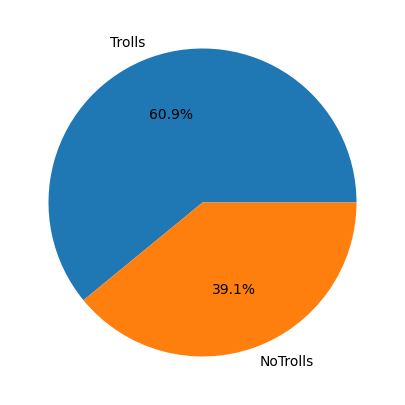

In [4]:
def plot_class_distribution(data):
    classes = data.iloc[:,-1].value_counts()
    plt.figure(figsize = (7, 5))
    return plt.pie(classes, labels = ['Trolls', 'NoTrolls'], autopct = "%1.1f%%")
plot_class_distribution(primary_data);

In [5]:
sentences = primary_data.content.to_list()
labels = primary_data.labels.to_numpy()

In [6]:
sentences[:5], labels[:5]

(["I guess everything's alright but I hate this still.",
  "Alors NERD s'&#233;tait bien ? vous avez du &#234;tre folles pendant lapdance XD &#224; SAMEDIIII &lt;3",
  'i hate how it never snows there... and you live IN CANADA! do you want some of ours? I hate snow.',
  ' If you could have a super power  what would it be?',
  'What the /fuck/? XD'],
 array([1, 1, 1, 0, 0]))

In [7]:
split_size = int(0.7 * len(sentences))
train_sentences , train_labels = sentences[:split_size], labels[:split_size]
test_sentences, test_labels = sentences[split_size:], labels[split_size:]

In [8]:
train_sentences[:5], train_labels[:5]

(["I guess everything's alright but I hate this still.",
  "Alors NERD s'&#233;tait bien ? vous avez du &#234;tre folles pendant lapdance XD &#224; SAMEDIIII &lt;3",
  'i hate how it never snows there... and you live IN CANADA! do you want some of ours? I hate snow.',
  ' If you could have a super power  what would it be?',
  'What the /fuck/? XD'],
 array([1, 1, 1, 0, 0]))

In [9]:
test_sentences[:5], test_labels[:5]

(['  I really liked aggravation :)',
  'damn damn damn James....',
  "not to sound amazingly  astoundingly gay (not that that's bad) but you sound like a man in desperate need of a few pillow shams",
  "I just noticed that they're opening for 'em. Damn  I'm stupid.",
  "-politicians should have to pass an ethics exam 2x yearly. I wonder if that's a piss test for them?"],
 array([0, 1, 1, 0, 1]))

In [14]:
def char_split(text):
    return " ".join(list(text))
    
class CharMaker:
    def __init__(self, text, lists):
        self.text = text
        self.lists = lists
        
    def char_maker(lists):
        char = [char_split(i) for i in lists]
        return char

In [15]:
train_char = CharMaker.char_maker(train_sentences)
test_char = CharMaker.char_maker(test_sentences)
print(f"Train Chars : \n {train_char[:5]}, \n\nTest Chars: \n {test_char[:5]}")

Train Chars : 
 ["I   g u e s s   e v e r y t h i n g ' s   a l r i g h t   b u t   I   h a t e   t h i s   s t i l l .", "A l o r s   N E R D   s ' & # 2 3 3 ; t a i t   b i e n   ?   v o u s   a v e z   d u   & # 2 3 4 ; t r e   f o l l e s   p e n d a n t   l a p d a n c e   X D   & # 2 2 4 ;   S A M E D I I I I   & l t ; 3", 'i   h a t e   h o w   i t   n e v e r   s n o w s   t h e r e . . .   a n d   y o u   l i v e   I N   C A N A D A !   d o   y o u   w a n t   s o m e   o f   o u r s ?   I   h a t e   s n o w .', '  I f   y o u   c o u l d   h a v e   a   s u p e r   p o w e r     w h a t   w o u l d   i t   b e ?', 'W h a t   t h e   / f u c k / ?   X D'], 

Test Chars: 
 ['    I   r e a l l y   l i k e d   a g g r a v a t i o n   : )', 'd a m n   d a m n   d a m n   J a m e s . . . .', "n o t   t o   s o u n d   a m a z i n g l y     a s t o u n d i n g l y   g a y   ( n o t   t h a t   t h a t ' s   b a d )   b u t   y o u   s o u n d   l i k e   a   m a n   i n   d e s p e

In [16]:
import numpy as np
char_len = [len(char) for char in train_char]
avg_char_len = np.mean(char_len)
avg_char_len

134.94587301587302

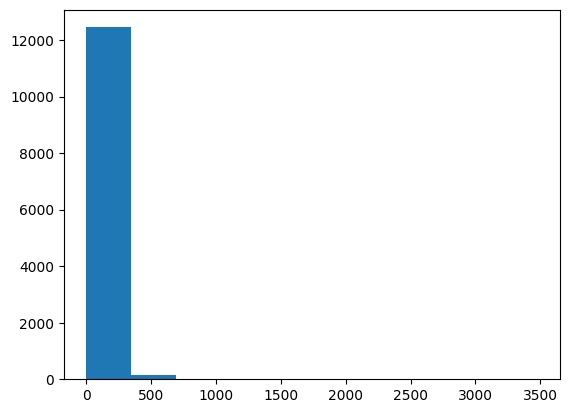

In [17]:
plt.hist(char_len);

In [19]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

257

In [20]:
alphabets = string.ascii_lowercase + string.punctuation + string.digits
NUM_CHAR_TOKENS = len(alphabets) + 2
char_vectorization = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                                      output_sequence_length = output_seq_char_len)
char_vectorization.adapt(train_char)

In [21]:
NUM_CHAR_TOKENS

70

In [24]:
char_embedding = tf.keras.layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                                          output_dim = 25,
                                          mask_zero = False,
                                          name = 'char_embed_layer')

In [25]:
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                         trainable = False,
                                         name = 'USE_LAYER')

In [27]:
class Dataset:
    def __init__(self, sentences, chars, labels):
        self.sentences = sentences
        self.chars = chars
        self.labels = labels
        
    def create_datasets(sentences, labels):
        data = tf.data.Dataset.from_tensor_slices(sentences)
        labels = tf.data.Dataset.from_tensor_slices(labels)
        dataset = tf.data.Dataset.zip((data, labels))
        dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
        return dataset
    
    def create_token_char_datasets(sentences, chars, labels):
        data = tf.data.Dataset.from_tensor_slices((sentences, chars))
        labels = tf.data.Dataset.from_tensor_slices(labels)
        token_dataset = tf.data.Dataset.zip((data, labels))
        token_dataset = token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
        return token_dataset

In [28]:
train_dataset = Dataset.create_datasets(train_sentences, train_labels)
test_dataset = Dataset.create_datasets(test_sentences, test_labels)
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [29]:
train_token_char_dataset = Dataset.create_token_char_datasets(train_sentences, train_char, train_labels)
test_token_char_dataset = Dataset.create_token_char_datasets(test_sentences, test_char, test_labels)
train_token_char_dataset, test_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [30]:

# Create a pipeline
baseline_model = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
baseline_model.fit(train_sentences, train_labels);
baseline_result = baseline_model.score(test_sentences, test_labels)
baseline_result

0.765969264950935

In [31]:
# token model:
token_input = tf.keras.layers.Input(shape = [], dtype = tf.string, name = 'token_model_input')
pretrained_embedding_layer = tf_hub_embedding_layer(token_input)
token_output = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_embedding_layer)
token_model = tf.keras.Model(inputs = token_input,
                            outputs = token_output)

# char model:
char_input = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = 'char_model_input')
char_vectors = char_vectorization(char_input)
char_embed = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
char_model = tf.keras.Model(inputs = char_input,
                            outputs = char_bi_lstm)
# hybrid model:
combined_model = tf.keras.layers.Concatenate(name = 'token_char_hybrid')([token_model.output, char_model.output])

# adding_dropout and dense layer:
combined_dropout = tf.keras.layers.Dropout(0.5)(combined_model)
combined_dense = tf.keras.layers.Dense(200, activation = 'relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')(final_dropout)

# final model:
model = tf.keras.Model(inputs = [token_model.input, char_model.input], outputs = output_layer)

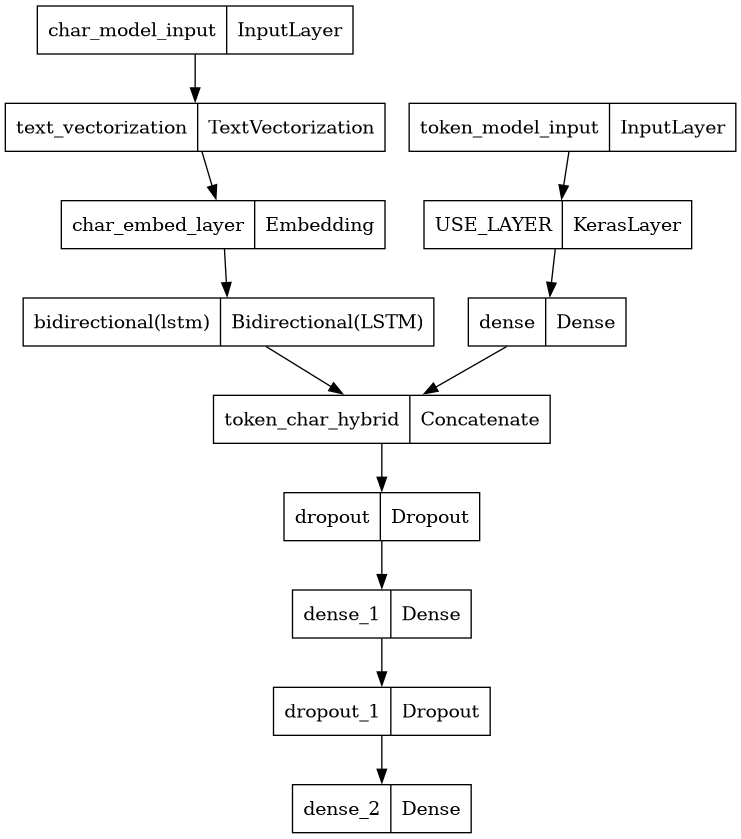

In [69]:
tf.keras.utils.plot_model(model)

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_model_input (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 token_model_input (InputLa  [(None,)]                    0         []                            
 yer)                                                                                             
                                                                                                  
 text_vectorization (TextVe  (None, 257)                  0         ['char_model_input[0][0]']    
 ctorization)                                                                               

In [34]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_2 = model.fit(train_token_char_dataset,
                      epochs = 30,
                      steps_per_epoch =  len(train_token_char_dataset),
                      validation_data = test_token_char_dataset,
                      callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                                        patience = 3, verbose = 1),
                                   tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                                    patience = 5, 
                                                                    restore_best_weights = True)])

Epoch 1/30
394/394 [==============================] - 26s 43ms/step - loss: 0.5618 - accuracy: 0.6832 - val_loss: 0.5088 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 2/30
394/394 [==============================] - 11s 29ms/step - loss: 0.4997 - accuracy: 0.7291 - val_loss: 0.4862 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 3/30
394/394 [==============================] - 11s 29ms/step - loss: 0.4660 - accuracy: 0.7588 - val_loss: 0.4679 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 4/30
394/394 [==============================] - 12s 30ms/step - loss: 0.4266 - accuracy: 0.7913 - val_loss: 0.4519 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 5/30
394/394 [==============================] - 11s 29ms/step - loss: 0.3896 - accuracy: 0.8167 - val_loss: 0.4323 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 6/30
394/394 [==============================] - 12s 29ms/step - loss: 0.3489 - accuracy: 0.8421 - val_loss: 0.4141 - val_accuracy: 0.8074 - lr: 0.0010
Epoch 7/30
394/394 [==============================] - 11s 

In [50]:
def plot_loss_curves(history):
    epochs = range(len(history.history['loss']))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(epochs, loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.xlabel('epochs')
    plt.ylabel('Training and Validation Loss')
    plt.legend();
    plt.figure()
    plt.plot(epochs, accuracy, label = 'Training Loss')
    plt.plot(epochs, val_accuracy, label = 'Validation Loss')
    plt.xlabel('epochs')
    plt.ylabel('Training and Validation Accuracy')
    plt.legend();
    

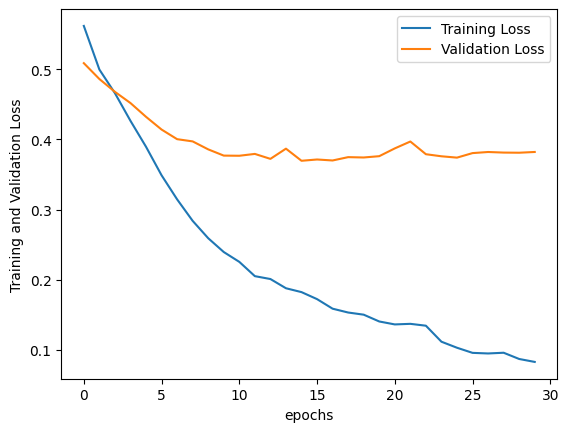

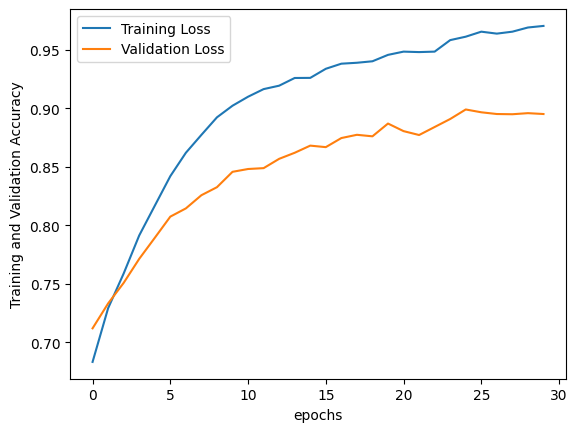

In [51]:
plot_loss_curves(history_2)

In [53]:
hybrid_model_result = model.evaluate(test_token_char_dataset)
hybrid_model_result

169/169 [==============================] - 2s 12ms/step - loss: 0.3741 - accuracy: 0.8991


[0.37408772110939026, 0.8990927338600159]

In [57]:
hybrid_model_pred_probs = model.predict(test_token_char_dataset)
hybrid_model_preds = tf.round(hybrid_model_pred_probs)
hybrid_model_preds[:10]

169/169 [==============================] - 2s 11ms/step


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [64]:
token_input = tf.keras.layers.Input(shape = [], dtype = tf.string, name = 'token_model_input')
pretrained_embedding_layer = tf_hub_embedding_layer(token_input)
token_dense = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_embedding_layer)
token_output = tf.keras.layers.Dense(1, activation = 'sigmoid')(token_dense)
token_model = tf.keras.Model(inputs = token_input,
                            outputs = token_output)

In [66]:
token_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_model_input (InputLa  [(None,)]                 0         
 yer)                                                            
                                                                 
 USE_LAYER (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256863617 (979.86 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [67]:
token_model.compile(loss= 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = token_model.fit(train_dataset,
                         epochs = 30,
                         validation_data = test_dataset,
                         steps_per_epoch = len(train_dataset),
                         callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                                        patience = 3, verbose = 1),
                                   tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                                    patience = 5, 
                                                                    restore_best_weights = True)])

Epoch 1/30
394/394 [==============================] - 9s 20ms/step - loss: 0.5575 - accuracy: 0.6918 - val_loss: 0.5176 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 2/30
394/394 [==============================] - 6s 15ms/step - loss: 0.5041 - accuracy: 0.7296 - val_loss: 0.5003 - val_accuracy: 0.7265 - lr: 0.0010
Epoch 3/30
394/394 [==============================] - 6s 15ms/step - loss: 0.4785 - accuracy: 0.7477 - val_loss: 0.4872 - val_accuracy: 0.7358 - lr: 0.0010
Epoch 4/30
394/394 [==============================] - 6s 16ms/step - loss: 0.4518 - accuracy: 0.7737 - val_loss: 0.4750 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 5/30
394/394 [==============================] - 6s 15ms/step - loss: 0.4224 - accuracy: 0.8014 - val_loss: 0.4629 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 6/30
394/394 [==============================] - 6s 16ms/step - loss: 0.3907 - accuracy: 0.8290 - val_loss: 0.4508 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 7/30
394/394 [==============================] - 6s 15ms/st

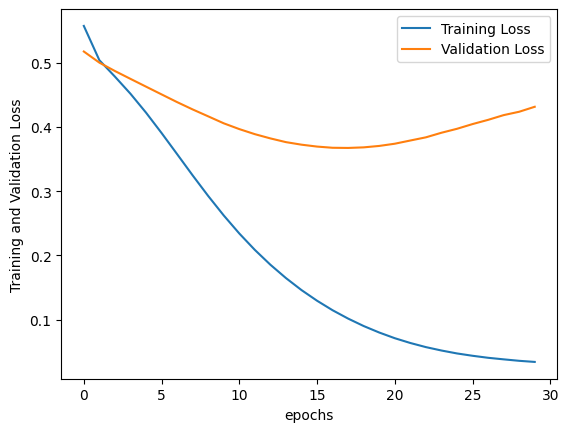

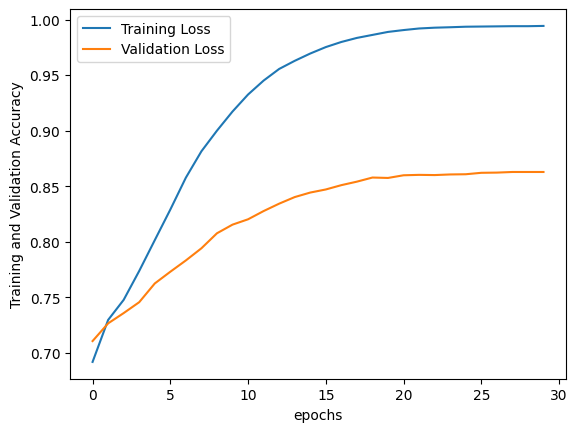

In [68]:
plot_loss_curves(history)